In [1]:
import numpy as np
import pandas as pd 
from matplotlib import cm
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [2]:
PATH = '/Users/eduardoaraujo/Documents/Github/paper-dengue-sc/data/cases'


In [3]:
dict_states = {
    'ne' : ['AL', 'BA', 'CE','MA', 'PB', 'PE', 'PI', 'SE', 'RN'],
    'sud' : ['SP', 'MG', 'RJ', 'ES'],
    'sul':  ['RS', 'SC', 'PR'],
    'ceo' : ['DF', 'GO', 'MT', 'MS'],
    'no' : ['AM', 'AP', 'TO', 'RR', 'RO' ,'AC', 'PA']
    
}


The function below will select the 20 cities with the most notified chikungunya cases by region (it was considered only the cities with more than 50 cases notified over the entire year): 

In [4]:
%%time 


df_end = pd.DataFrame()

for label in dict_states.keys():
    
    cities_fill = []
    states = []
    max_cases = []

    for state in dict_states[label]:
        
        dfc = pd.read_parquet(f'{PATH}/{state}_chik.parquet', columns = ['casos','municipio_geocodigo'])
        dfc.index = pd.to_datetime(dfc.index)

        for c in dfc.municipio_geocodigo.unique():

            dfcity_23 = dfc.loc[(dfc.municipio_geocodigo == c) & (dfc.index.year == 2023)]

            cities_fill.append(c)
            states.append(state)
            
            try: 
                max_cases.append(sum(dfcity_23.casos))
                
            except: 
                max_cases.append(0)


    df = pd.DataFrame()

    df['geocode'] = cities_fill
    df['state'] = states
    df['sum_cases'] = max_cases

    df = df.loc[df.sum_cases >= 50]
    
    df = df.sort_values(by = 'sum_cases', ascending = False).iloc[:20]
    
    #print('------------------------------------------------------------------')
    #print(label)
    #print(df.state.value_counts())
    
    #df = df.iloc[:10]
    
    df_end = pd.concat([df_end, df])

df_end.head()



CPU times: user 40.6 s, sys: 1.13 s, total: 41.7 s
Wall time: 42.6 s


,geocode,state,sum_cases
1410,2211001,PI,2325
363,2913606,BA,1858
456,2914802,BA,1846
909,2111300,MA,1788
343,2925303,BA,1687


In [5]:
df_end.shape

(93, 3)

The cell below will add the info about the population of this cities and compute the incidence by 100k: 

In [6]:
filepop = '/Users/eduardoaraujo/Documents/Github/paper-dengue-sc/poptcu2010-2022_rgi.csv'

pop = pd.read_csv(filepop, usecols = ['CODMUN7','POP22'])

df = df_end 

df = df.merge(pop,  left_on='geocode', right_on='CODMUN7')

del df['CODMUN7']

df['inc'] = 100000*df['sum_cases']/df['POP22']

df.head()

,geocode,state,sum_cases,POP22,inc
0,2211001,PI,2325,868523,267.695847
1,2913606,BA,1858,197163,942.367483
2,2914802,BA,1846,185500,995.148248
3,2111300,MA,1788,1061374,168.460882
4,2925303,BA,1687,158736,1062.770890


The cell below will add the number of chik epidemics computed by the episcanner before 23, and the year of the first epidemic identified:

In [7]:
def n_chik_ep(state, geocode):
    file_pars_episcanner= f'/Users/eduardoaraujo/Documents/Github/paper-dengue-sc/params/pars_{state}_chik.csv.gz'

    pars = pd.read_csv(file_pars_episcanner, index_col = 'Unnamed: 0')
    
    pars = pars.loc[(pars.geocode == geocode) & (pars.year < 2023)]
    
    try: 
        y = min(pars.year)
    except:
        y = 0

    return pars.shape[0], y

def first_ep(state, geocode):
    dfs = pd.read_parquet(f'{PATH}/{state}_chik.parquet')
    dfs.loc[dfs.municipio_geocodigo == geocode]
    dfs = dfs.resample('Y').sum()[['casos', 'p_inc100k']]
    dfs = dfs.loc[dfs.p_inc100k > 1000]
    
    try: 
        y =  min(dfs.index.year)
        
    except:
        y = 0
    return y

## Change the code below to apply: 

In [8]:
def process_row(row):
    n, y = n_chik_ep(state=row['state'], geocode=row['geocode'])
    y2 = first_ep(state=row['state'], geocode=row['geocode'])
    return pd.Series({'n_last_ep': n, 'year_first_ep': y,
                     'year_f_ep_2':y2})

# Aplicando a função a cada linha do DataFrame e atribuindo os resultados às novas colunas
df[['n_last_ep', 'year_first_ep', 'year_f_ep_2']] = df.apply(process_row, axis=1)
df

/var/folders/ch/kxpr39wx44v97968yr_4hmch0000gn/T/ipykernel_5419/3300733840.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dfs = dfs.resample('Y').sum()[['casos', 'p_inc100k']]
/var/folders/ch/kxpr39wx44v97968yr_4hmch0000gn/T/ipykernel_5419/3300733840.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dfs = dfs.resample('Y').sum()[['casos', 'p_inc100k']]
/var/folders/ch/kxpr39wx44v97968yr_4hmch0000gn/T/ipykernel_5419/3300733840.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_on

/var/folders/ch/kxpr39wx44v97968yr_4hmch0000gn/T/ipykernel_5419/3300733840.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dfs = dfs.resample('Y').sum()[['casos', 'p_inc100k']]
/var/folders/ch/kxpr39wx44v97968yr_4hmch0000gn/T/ipykernel_5419/3300733840.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dfs = dfs.resample('Y').sum()[['casos', 'p_inc100k']]
/var/folders/ch/kxpr39wx44v97968yr_4hmch0000gn/T/ipykernel_5419/3300733840.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_on

/var/folders/ch/kxpr39wx44v97968yr_4hmch0000gn/T/ipykernel_5419/3300733840.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dfs = dfs.resample('Y').sum()[['casos', 'p_inc100k']]
/var/folders/ch/kxpr39wx44v97968yr_4hmch0000gn/T/ipykernel_5419/3300733840.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dfs = dfs.resample('Y').sum()[['casos', 'p_inc100k']]
/var/folders/ch/kxpr39wx44v97968yr_4hmch0000gn/T/ipykernel_5419/3300733840.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_on

/var/folders/ch/kxpr39wx44v97968yr_4hmch0000gn/T/ipykernel_5419/3300733840.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dfs = dfs.resample('Y').sum()[['casos', 'p_inc100k']]
/var/folders/ch/kxpr39wx44v97968yr_4hmch0000gn/T/ipykernel_5419/3300733840.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dfs = dfs.resample('Y').sum()[['casos', 'p_inc100k']]
/var/folders/ch/kxpr39wx44v97968yr_4hmch0000gn/T/ipykernel_5419/3300733840.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_on

,geocode,state,sum_cases,POP22,inc,n_last_ep,year_first_ep,year_f_ep_2
0,2211001,PI,2325,868523,267.695847,4,2015,2016
1,2913606,BA,1858,197163,942.367483,2,2015,2015
2,2914802,BA,1846,185500,995.148248,2,2016,2015
3,2111300,MA,1788,1061374,168.460882,2,2016,2016
4,2925303,BA,1687,158736,1062.770890,2,2016,2015
...,...,...,...,...,...,...,...,...
88,1400100,RR,137,408157,33.565515,2,2015,2017
89,1700350,TO,122,4932,2473.641525,0,0,2015
90,1400175,RR,119,18030,660.011093,0,0,2017
91,1503200,PA,116,35788,324.130994,0,0,2016


In [9]:
df.loc[df.year_f_ep_2 == 0]

,geocode,state,sum_cases,POP22,inc,n_last_ep,year_first_ep,year_f_ep_2
55,5300108,DF,946,2923369,32.359924,0,0,0
85,1302603,AM,164,2054731,7.981580,0,0,0


In [10]:
file_pars_episcanner= f'/Users/eduardoaraujo/Documents/Github/paper-dengue-sc/params/pars_DF_chik.csv.gz'

pars = pd.read_csv(file_pars_episcanner, index_col = 'Unnamed: 0')

pars.loc[pars.geocode == 5300108]

,geocode,muni_name,year,peak_week,beta,gamma,R0,total_cases,alpha,sum_res,ep_ini,ep_end,ep_dur


In [11]:
df.loc[df.year_first_ep == 0]

,geocode,state,sum_cases,POP22,inc,n_last_ep,year_first_ep,year_f_ep_2
14,2905909,BA,600,30659,1957.010992,0,0,2015
18,2908705,BA,498,17059,2919.280145,0,0,2015
21,3106200,MG,7600,2392678,317.635720,0,0,2016
22,3167202,MG,5935,233398,2542.866691,0,0,2016
25,3154606,MG,3677,327968,1121.145965,0,0,2016
26,3205101,ES,3514,71443,4918.606441,0,0,2017
29,3118601,MG,3227,615621,524.186147,0,0,2016
30,3203320,ES,2934,46198,6350.924282,0,0,2017
31,3157807,MG,2919,213709,1365.876028,0,0,2016
32,3135100,MG,2545,70001,3635.662348,0,0,2016


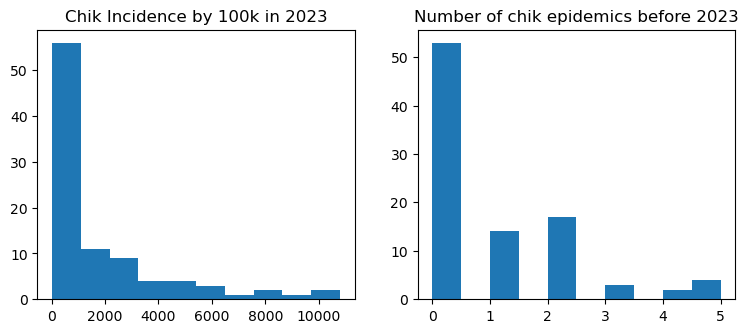

In [12]:
fig, ax = plt.subplots(1,2, figsize = (9, 3.5))

ax[0].hist(df.inc)

ax[0].set_title('Chik Incidence by 100k in 2023')

ax[1].hist(df.n_last_ep)

ax[1].set_title('Number of chik epidemics before 2023')

plt.show()

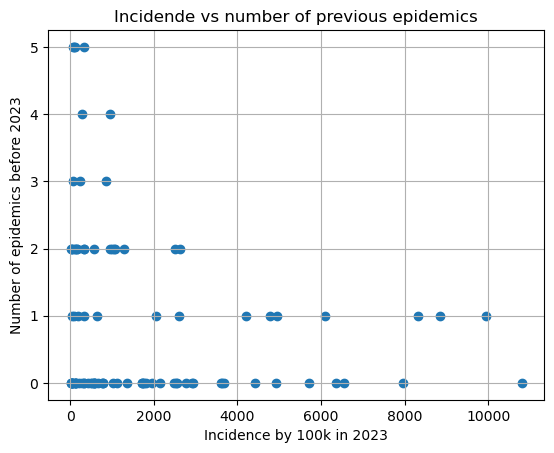

In [13]:
fig, ax = plt.subplots()

ax.scatter( df.inc, df.n_last_ep)

ax.grid()

ax.set_ylabel('Number of epidemics before 2023')
ax.set_xlabel('Incidence by 100k in 2023')

ax.set_title('Incidende vs number of previous epidemics')

plt.show()

In [14]:
df['region'] = np.nan

for key in dict_states.keys():
    
    df.loc[df.state.isin(dict_states[key]), 'region'] = key
    

    
le = LabelEncoder().fit(df['region'])
region_labels = le.classes_
df['region_codes'] = le.transform(df['region'])
df['region_codes'] = df['region_codes'].astype('category')

df

,geocode,state,sum_cases,POP22,inc,n_last_ep,year_first_ep,year_f_ep_2,region,region_codes
0,2211001,PI,2325,868523,267.695847,4,2015,2016,ne,1
1,2913606,BA,1858,197163,942.367483,2,2015,2015,ne,1
2,2914802,BA,1846,185500,995.148248,2,2016,2015,ne,1
3,2111300,MA,1788,1061374,168.460882,2,2016,2016,ne,1
4,2925303,BA,1687,158736,1062.770890,2,2016,2015,ne,1
...,...,...,...,...,...,...,...,...,...,...
88,1400100,RR,137,408157,33.565515,2,2015,2017,no,2
89,1700350,TO,122,4932,2473.641525,0,0,2015,no,2
90,1400175,RR,119,18030,660.011093,0,0,2017,no,2
91,1503200,PA,116,35788,324.130994,0,0,2016,no,2


/var/folders/ch/kxpr39wx44v97968yr_4hmch0000gn/T/ipykernel_5419/3028567897.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter( df.inc, df.n_last_ep, c = df.region_codes, cmap = cm.get_cmap('tab10', 5))


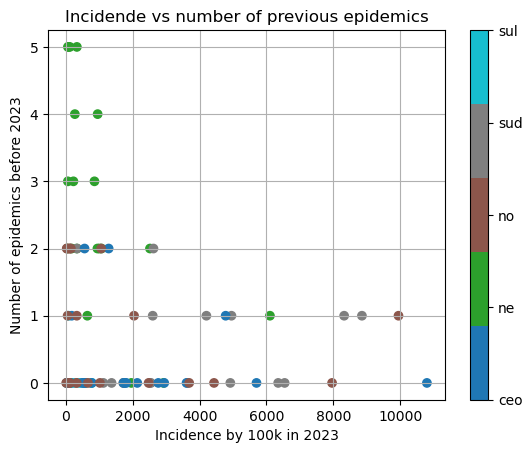

In [15]:
fig, ax = plt.subplots()

plt.scatter( df.inc, df.n_last_ep, c = df.region_codes, cmap = cm.get_cmap('tab10', 5))

cbar = plt.colorbar()
cbar.set_ticks(np.arange(len(region_labels)))
cbar.set_ticklabels(region_labels)
        
    
ax.grid()

ax.set_ylabel('Number of epidemics before 2023')
ax.set_xlabel('Incidence by 100k in 2023')

ax.set_title('Incidende vs number of previous epidemics')

plt.show()

In [16]:
df.head()

,geocode,state,sum_cases,POP22,inc,n_last_ep,year_first_ep,year_f_ep_2,region,region_codes
0,2211001,PI,2325,868523,267.695847,4,2015,2016,ne,1
1,2913606,BA,1858,197163,942.367483,2,2015,2015,ne,1
2,2914802,BA,1846,185500,995.148248,2,2016,2015,ne,1
3,2111300,MA,1788,1061374,168.460882,2,2016,2016,ne,1
4,2925303,BA,1687,158736,1062.770890,2,2016,2015,ne,1


In [17]:
df.region.value_counts()

ne     20
sud    20
ceo    20
no     20
sul    13
Name: region, dtype: int64

Removing the cities that the first epidemic was in 2023: 

In [18]:
df_end = df.loc[df.n_last_ep > 0]

df_end.head()

,geocode,state,sum_cases,POP22,inc,n_last_ep,year_first_ep,year_f_ep_2,region,region_codes
0,2211001,PI,2325,868523,267.695847,4,2015,2016,ne,1
1,2913606,BA,1858,197163,942.367483,2,2015,2015,ne,1
2,2914802,BA,1846,185500,995.148248,2,2016,2015,ne,1
3,2111300,MA,1788,1061374,168.460882,2,2016,2016,ne,1
4,2925303,BA,1687,158736,1062.770890,2,2016,2015,ne,1


In [19]:
df_end.region.value_counts()

ne     18
no     10
sud     7
ceo     4
sul     1
Name: region, dtype: int64

In [20]:
df_end.head()

,geocode,state,sum_cases,POP22,inc,n_last_ep,year_first_ep,year_f_ep_2,region,region_codes
0,2211001,PI,2325,868523,267.695847,4,2015,2016,ne,1
1,2913606,BA,1858,197163,942.367483,2,2015,2015,ne,1
2,2914802,BA,1846,185500,995.148248,2,2016,2015,ne,1
3,2111300,MA,1788,1061374,168.460882,2,2016,2016,ne,1
4,2925303,BA,1687,158736,1062.770890,2,2016,2015,ne,1


In [21]:
df_end.shape

(40, 10)

/var/folders/ch/kxpr39wx44v97968yr_4hmch0000gn/T/ipykernel_5419/3652897959.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter( df_end.inc, df_end.n_last_ep, c = df_end.region_codes, cmap = cm.get_cmap('tab10', 5))


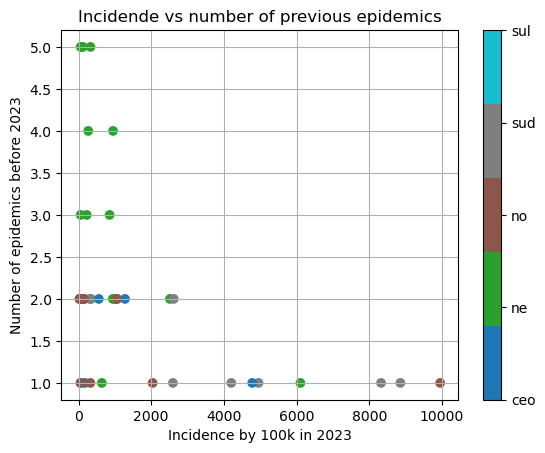

In [22]:
fig, ax = plt.subplots()

plt.scatter( df_end.inc, df_end.n_last_ep, c = df_end.region_codes, cmap = cm.get_cmap('tab10', 5))

cbar = plt.colorbar()
cbar.set_ticks(np.arange(len(region_labels)))
cbar.set_ticklabels(region_labels)
        
    
ax.grid()

ax.set_ylabel('Number of epidemics before 2023')
ax.set_xlabel('Incidence by 100k in 2023')

ax.set_title('Incidende vs number of previous epidemics')

plt.show()

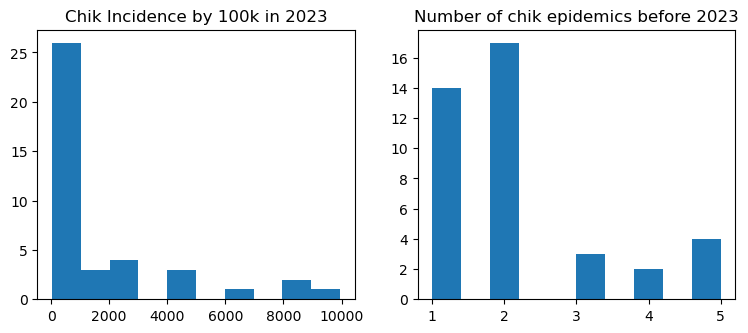

In [23]:
fig, ax = plt.subplots(1,2, figsize = (9, 3.5))

ax[0].hist( df_end.inc)

ax[0].set_title('Chik Incidence by 100k in 2023')

ax[1].hist( df_end.n_last_ep)

ax[1].set_title('Number of chik epidemics before 2023')

plt.show()

Looking at the time series of the selected cities: 

In [24]:
def make_plot(ax, state, city, norm = False):
    '''
    This function plot in a single figure the time series of dengue and chikungunya
    '''
    
    dfc = pd.read_parquet(f'{PATH}/{state}_chik.parquet', columns = ['casos','municipio_geocodigo'])
    dfc.index = pd.to_datetime(dfc.index)
    
    dfc = dfc.loc[dfc.municipio_geocodigo == city]

    dfc = dfc.sort_index()
    
    if norm: 
        dfc = dfc/max(dfc['casos'])
    
    
    dfd = pd.read_parquet(f'{PATH}/{state}_dengue.parquet', columns = ['casos', 'municipio_geocodigo'])
    dfd.index = pd.to_datetime(dfd.index)
    
    
    dfd = dfd.loc[dfd.municipio_geocodigo == city]

    dfd = dfd.sort_index()
    
    if norm: 
        dfd = dfd/max(dfd['casos'])
    
    
    ax.plot(dfd.casos, label = 'Dengue')
    ax.plot(dfc.casos, label = 'Chikungunya')
    
    ax.legend()
    
    ax.set_title(f'{state} - {city}')
    
    if norm: 
        ax.set_title(f'{state} - {city} (Normalized)')
    
    ax.set_xlabel('Date')
    
    ax.set_ylabel('New cases')
    
    ax.grid()

def make_plot_single(ax, state, city,disease = 'dengue', date1 = None, date2 = None):
    '''
    This function plot the time series of dengue or chikungunya
    
    '''
    dfc = pd.read_parquet(f'{PATH}/{state}_{disease}.parquet', columns = ['casos','municipio_geocodigo'])
    dfc.index = pd.to_datetime(dfc.index)
    
    dfc = dfc.loc[dfc.municipio_geocodigo == city]

    dfc = dfc.sort_index()
    
    if date1 != None:
        ax.axvline(pd.to_datetime(date1), color = 'tab:red', ls = '--')
        
    if date2 != None:
        ax.axvline(pd.to_datetime(date2), color = 'tab:green', ls = '--')
        
    ax.plot(dfc.casos)

    ax.set_title(f'{disease.capitalize()} cases at {state} - {city}')
    
    ax.set_xlabel('Date')
    
    ax.set_ylabel('New cases')
    
    ax.grid()

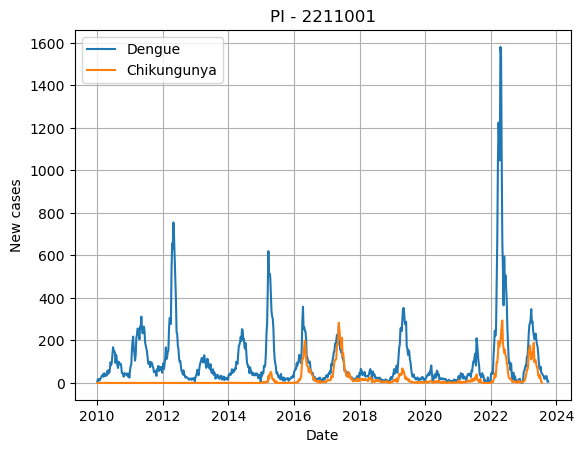

In [25]:
fig,ax = plt.subplots()

make_plot(ax, 'PI', 2211001)

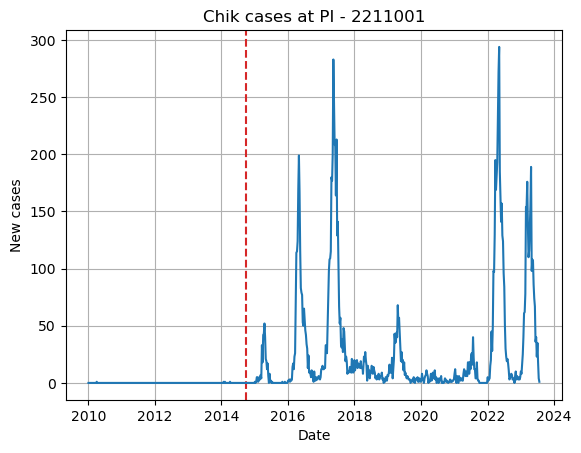

In [26]:
fig,ax = plt.subplots()

make_plot_single(ax, 'PI', 2211001, disease = 'chik', date1 = '2014-10-01')

There is dengue cases notified in most of cities since 2010, but the chik cases appear later an in diferent periods of times in different regions. For this reason, we will assume as start date to the chik models, the first of october of the previous year of the first epidemic identified by episcanner. 

In [27]:
def calculate_start_date(year):
    return f'{year - 1}-10-01'

# Aplicando a função a cada elemento da coluna 'year_first_ep' e atribuindo os resultados à nova coluna
df_end['start_train_chik'] = df_end['year_first_ep'].apply(calculate_start_date)
df_end['start_train_chik2'] = df_end['year_f_ep_2'].apply(calculate_start_date)

df_end.head()

/var/folders/ch/kxpr39wx44v97968yr_4hmch0000gn/T/ipykernel_5419/3936037186.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_end['start_train_chik'] = df_end['year_first_ep'].apply(calculate_start_date)
/var/folders/ch/kxpr39wx44v97968yr_4hmch0000gn/T/ipykernel_5419/3936037186.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_end['start_train_chik2'] = df_end['year_f_ep_2'].apply(calculate_start_date)


,geocode,state,sum_cases,POP22,inc,n_last_ep,year_first_ep,year_f_ep_2,region,region_codes,start_train_chik,start_train_chik2
0,2211001,PI,2325,868523,267.695847,4,2015,2016,ne,1,2014-10-01,2015-10-01
1,2913606,BA,1858,197163,942.367483,2,2015,2015,ne,1,2014-10-01,2014-10-01
2,2914802,BA,1846,185500,995.148248,2,2016,2015,ne,1,2015-10-01,2014-10-01
3,2111300,MA,1788,1061374,168.460882,2,2016,2016,ne,1,2015-10-01,2015-10-01
4,2925303,BA,1687,158736,1062.770890,2,2016,2015,ne,1,2015-10-01,2014-10-01


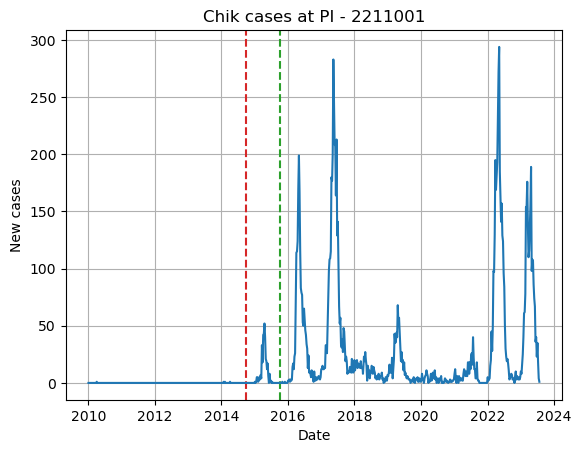

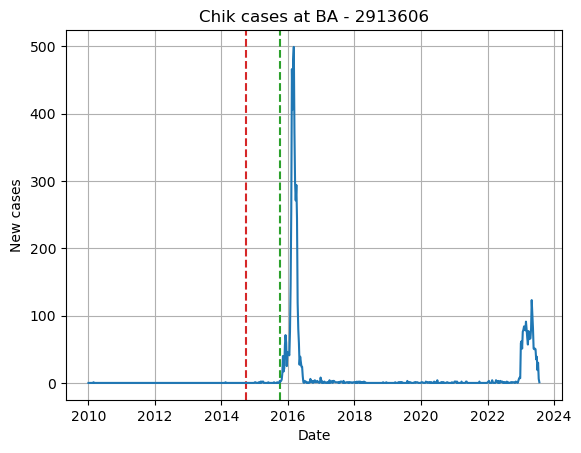

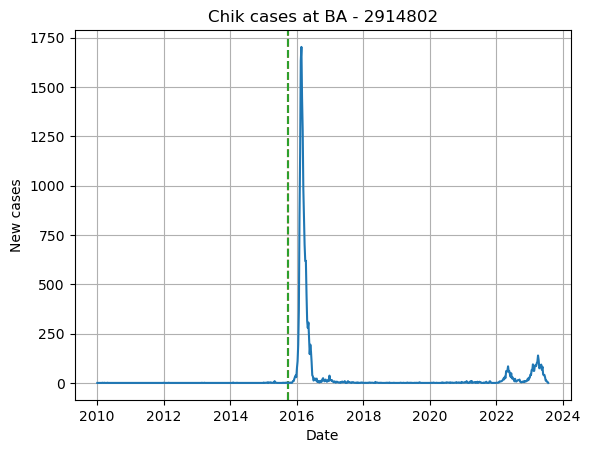

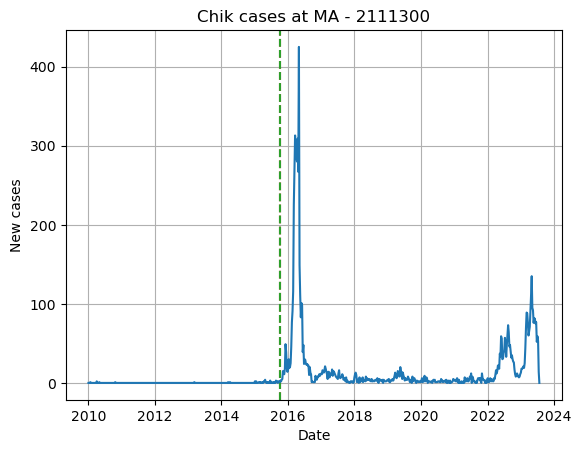

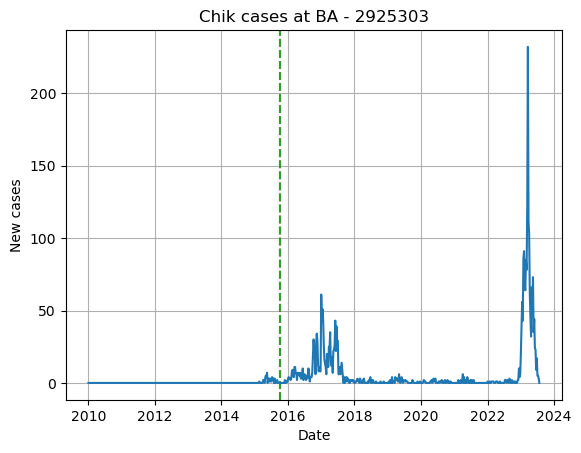

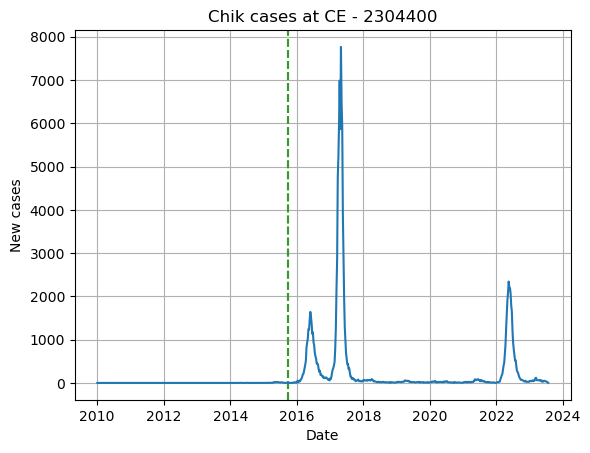

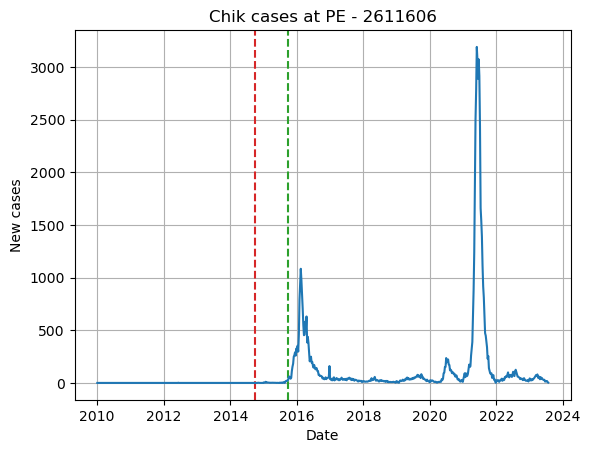

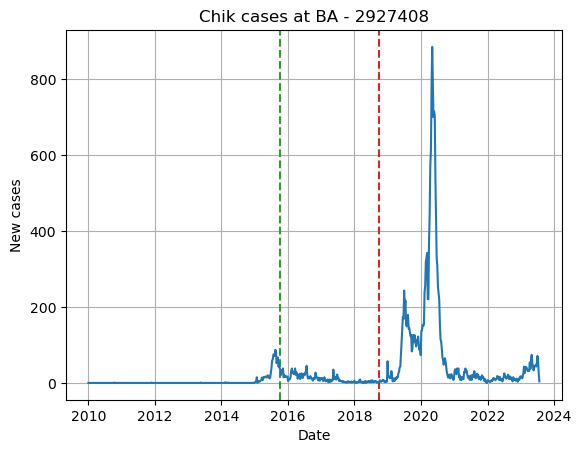

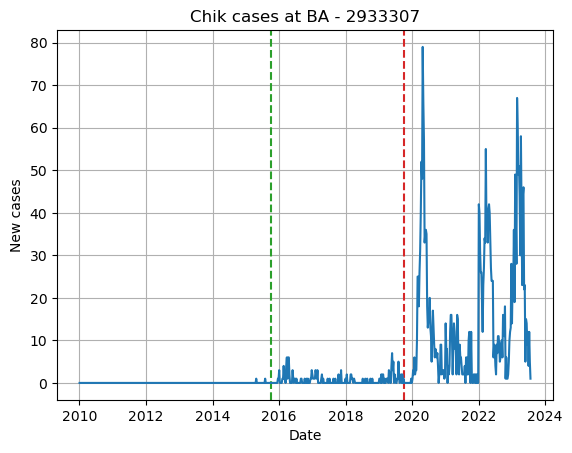

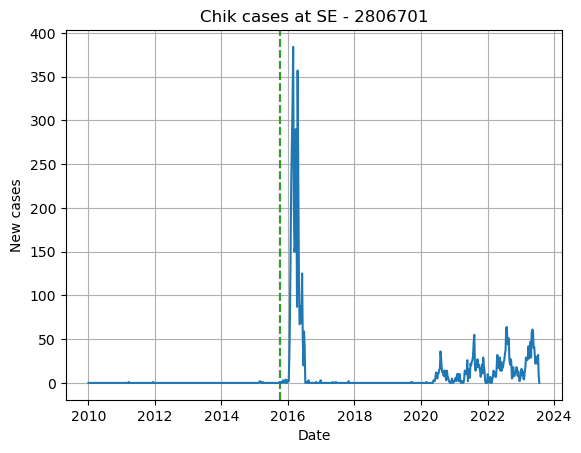

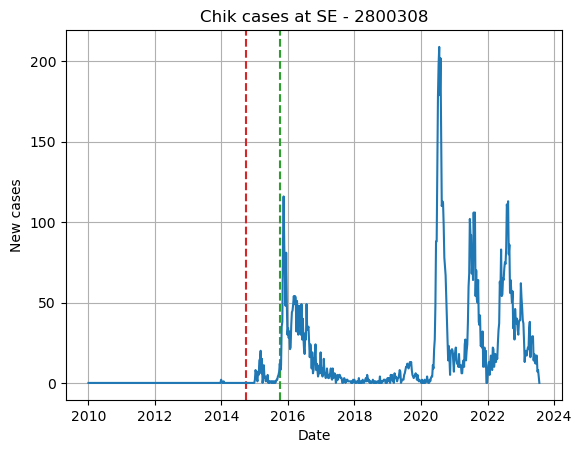

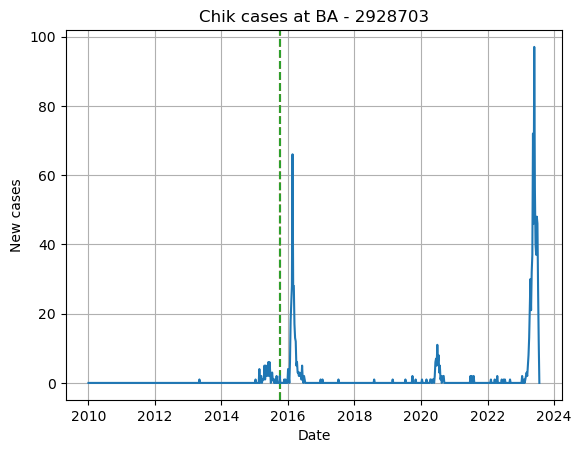

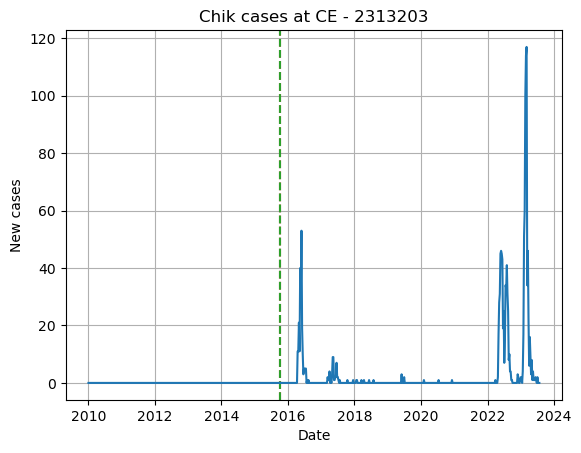

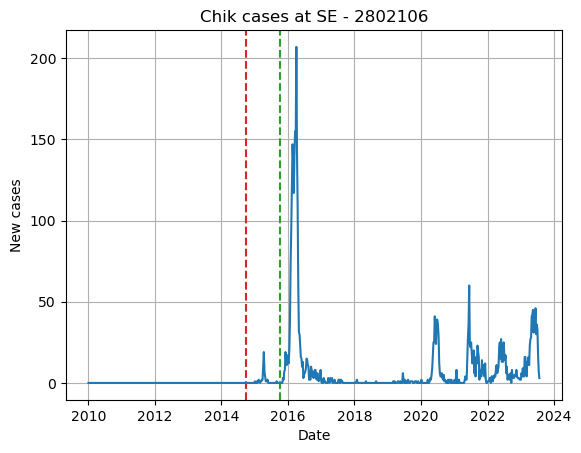

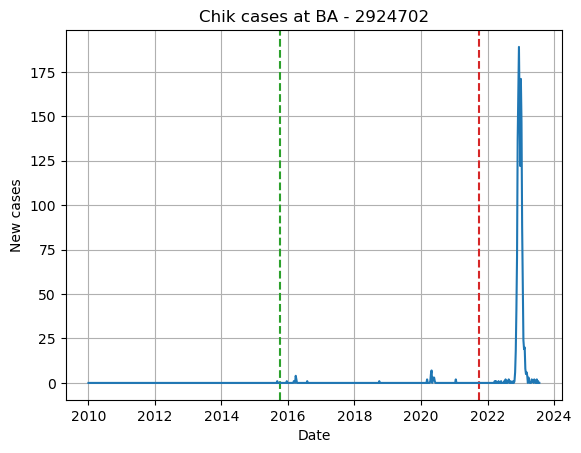

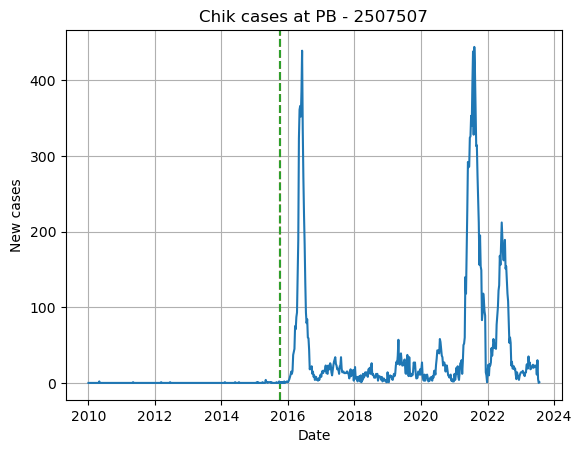

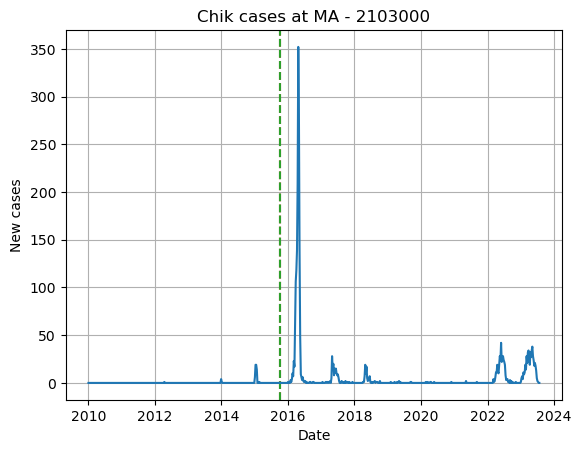

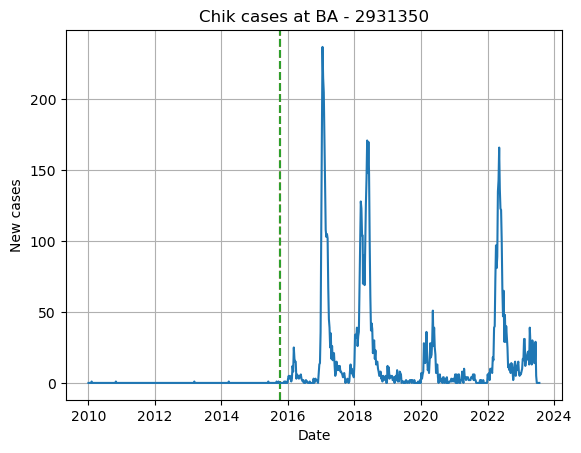

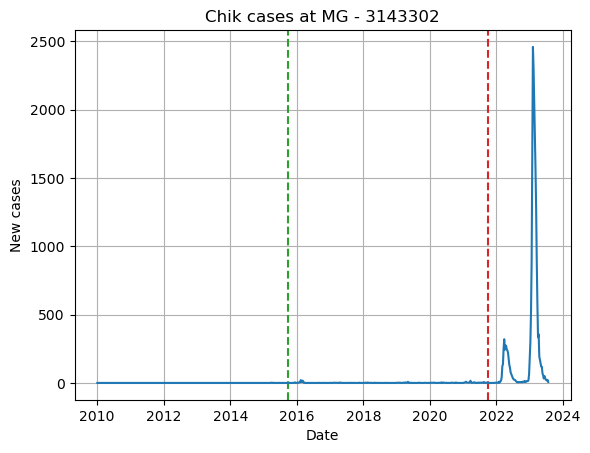

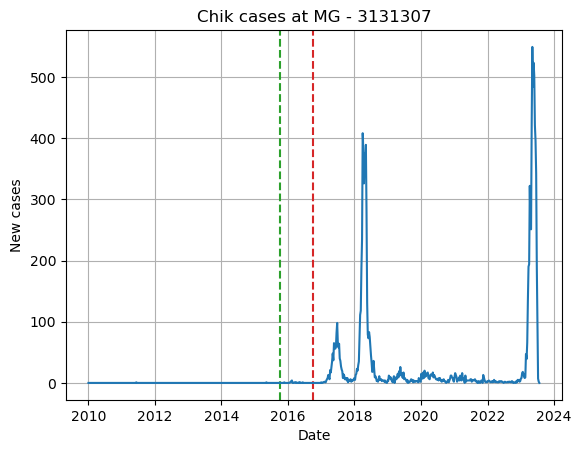

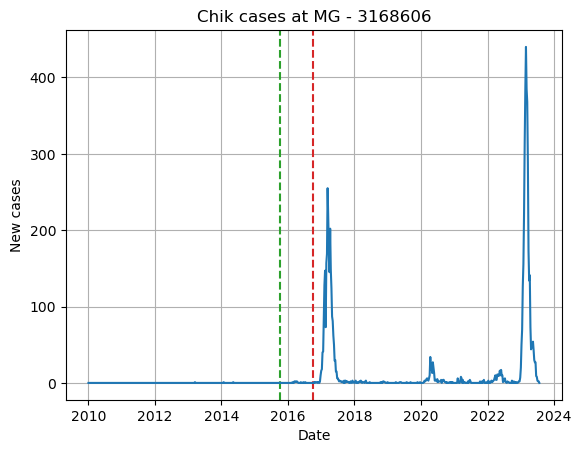

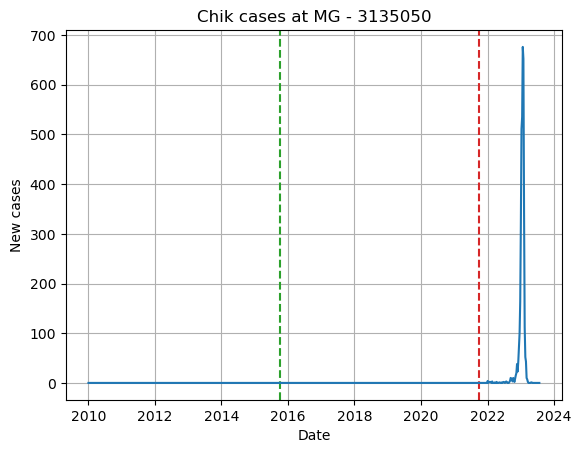

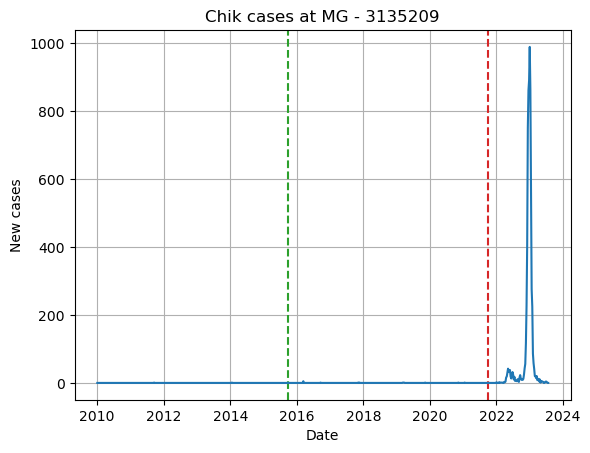

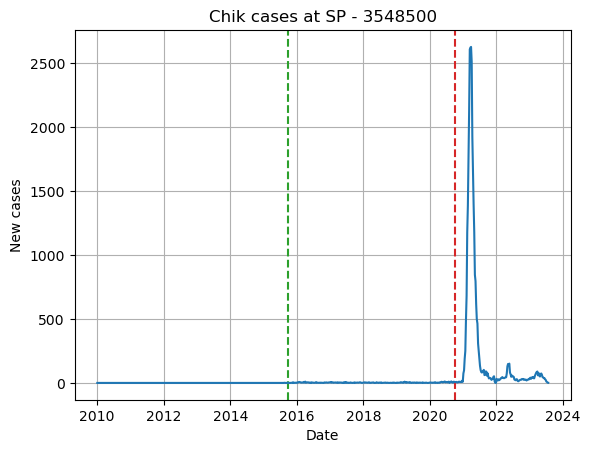

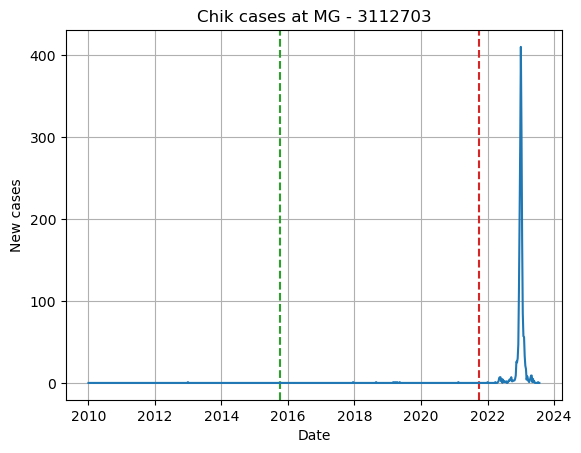

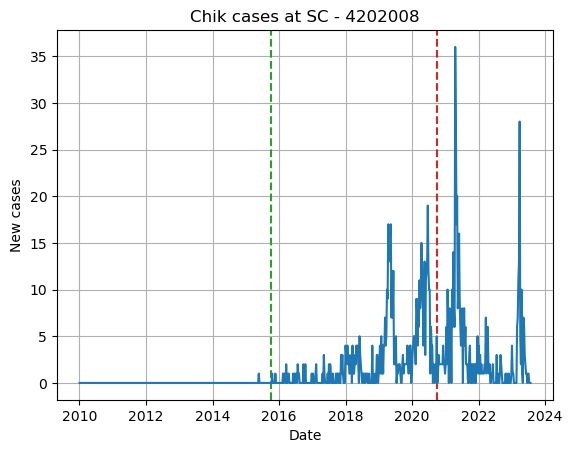

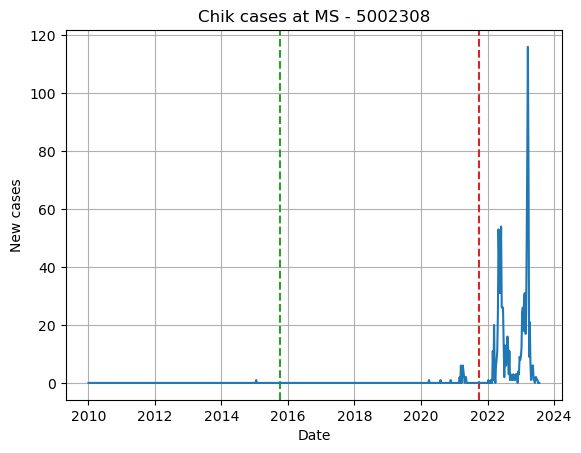

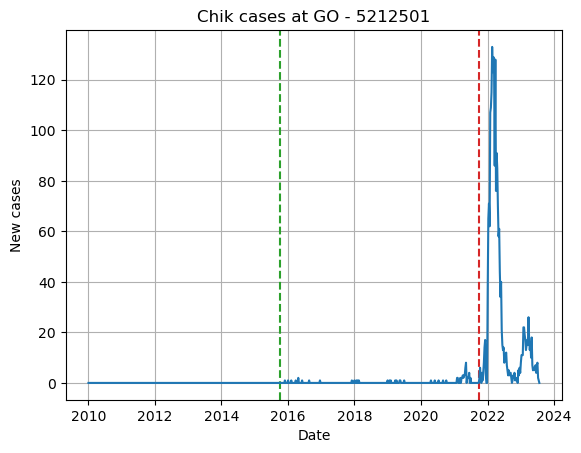

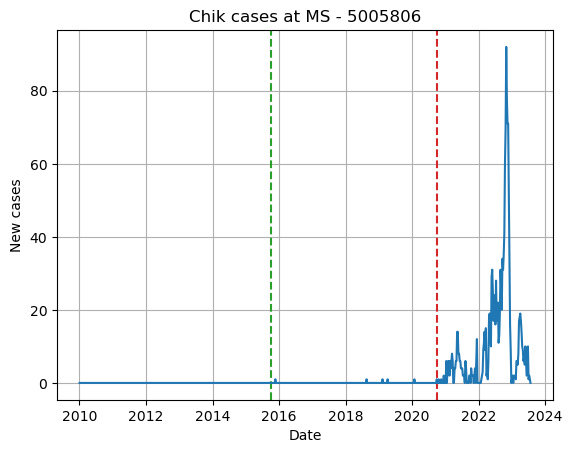

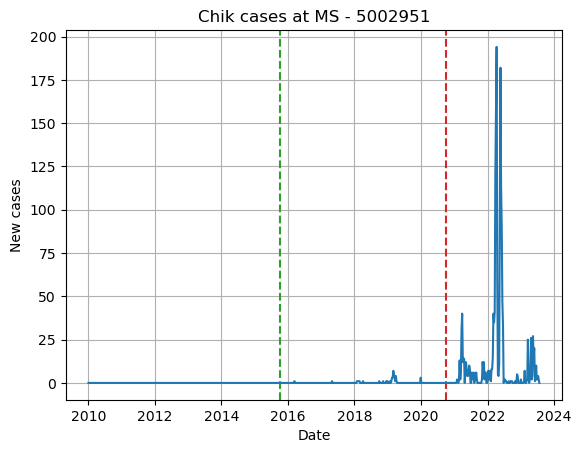

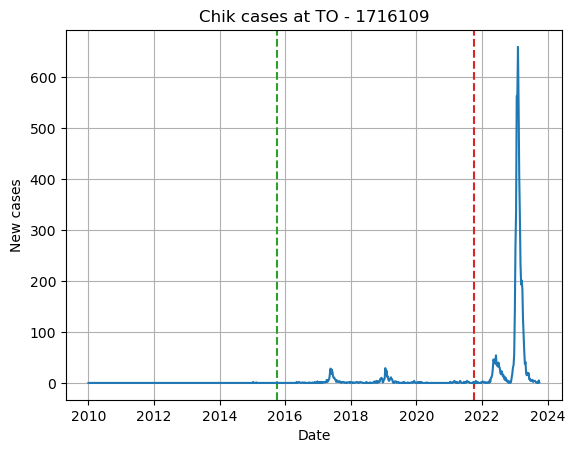

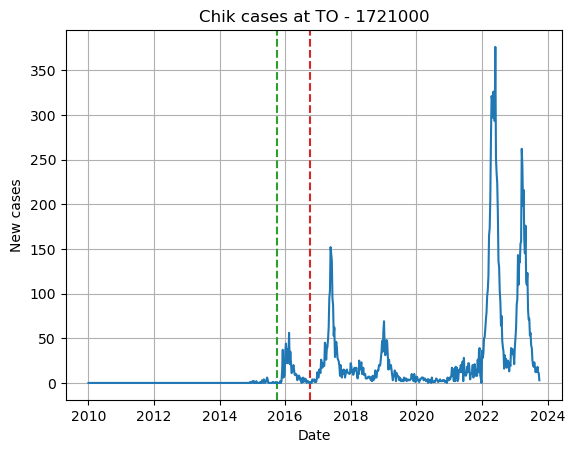

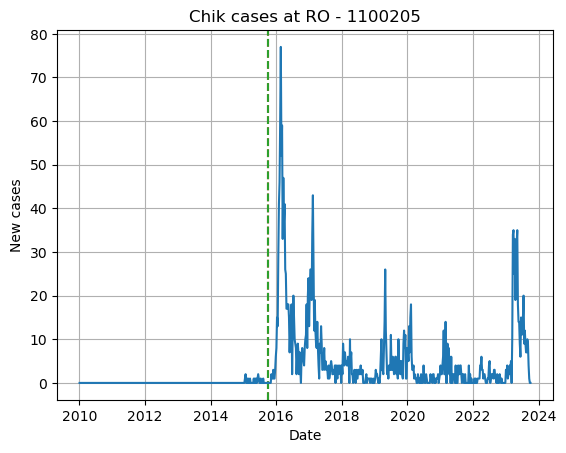

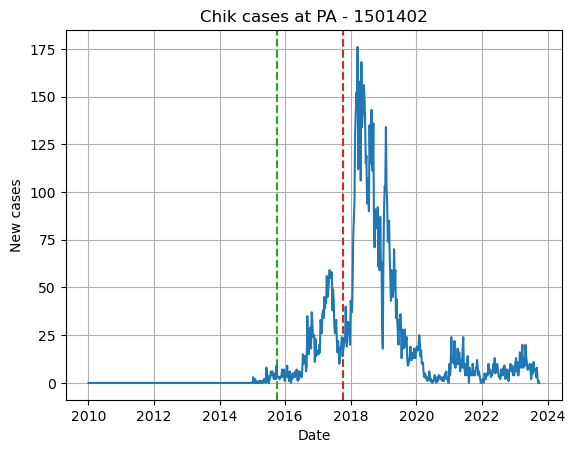

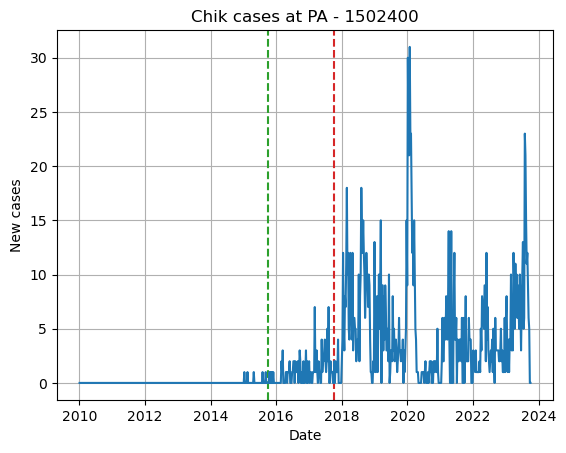

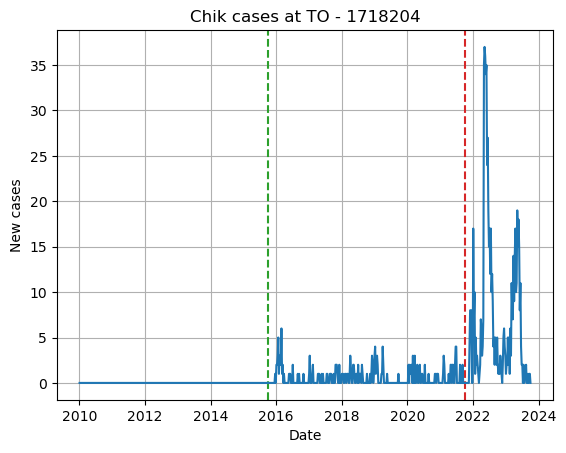

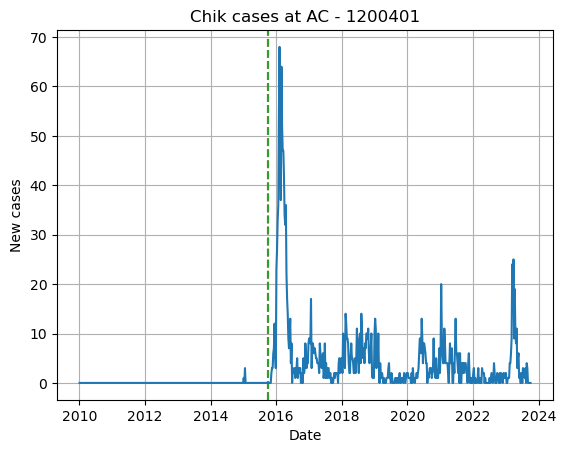

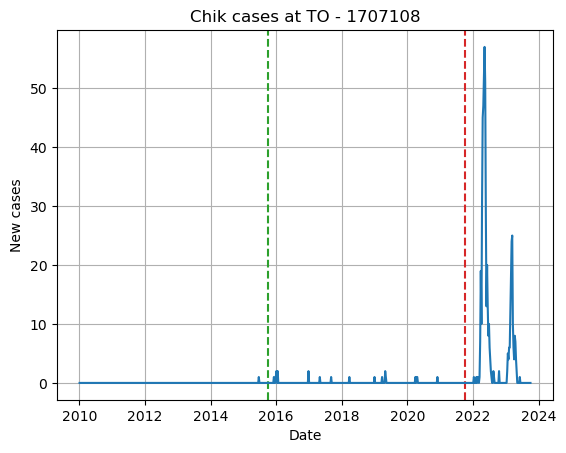

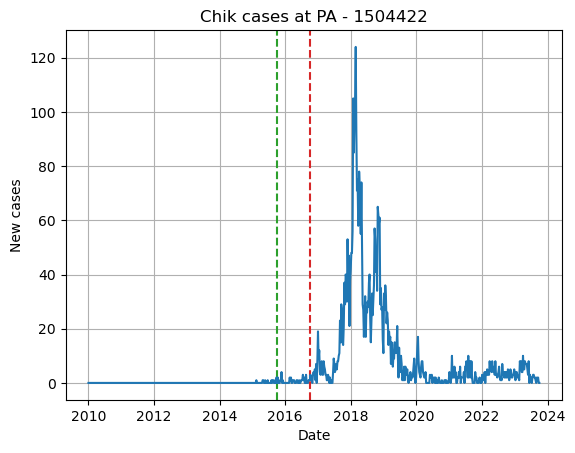

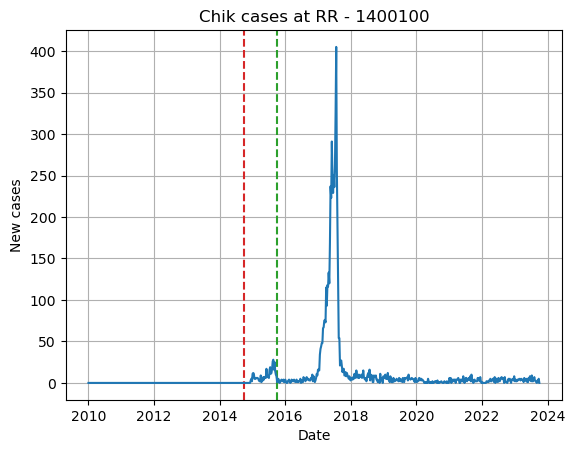

In [30]:
for s, g, d1, d2 in zip(df_end.state, df_end.geocode, df_end.start_train_chik, df_end.start_train_chik2):
    fig,ax = plt.subplots()

    make_plot_single(ax, s, g, disease = 'chik', date1 = d1, date2= '2015-10-01')
    
    plt.show()

In [29]:
df_end.head()

,geocode,state,sum_cases,POP22,inc,n_last_ep,year_first_ep,year_f_ep_2,region,region_codes,start_train_chik,start_train_chik2
0,2211001,PI,2325,868523,267.695847,4,2015,2016,ne,1,2014-10-01,2015-10-01
1,2913606,BA,1858,197163,942.367483,2,2015,2015,ne,1,2014-10-01,2014-10-01
2,2914802,BA,1846,185500,995.148248,2,2016,2015,ne,1,2015-10-01,2014-10-01
3,2111300,MA,1788,1061374,168.460882,2,2016,2016,ne,1,2015-10-01,2015-10-01
4,2925303,BA,1687,158736,1062.770890,2,2016,2015,ne,1,2015-10-01,2014-10-01


## Em alguns lugares parece haver problema no critério utilizado pelo episcanner 


In [ ]:
df_end.to_csv('selected_cities.csv')